In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import skimage
import os
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from defects_dlmbl.unetmodule import UNetModuleWithMetricAuxiliary
from defects_dlmbl.datasets import CREMIDataset
from defects_dlmbl.segment_affinities import mutex_watershed

In [3]:
os.chdir('/home/funkl/defects_DLMBL')

# load from checkpoints

In [4]:
f = 'experiments/lightning_logs/version_38/checkpoints/epoch=351-step=8799.ckpt'

In [5]:
trained_model = UNetModuleWithMetricAuxiliary.load_from_checkpoint(f)

# load full image

In [6]:
dataset = CREMIDataset('data/training_data.zarr',augment_and_crop=False,pad=5) 

In [7]:
raw,gt_affinities,gt_seg = dataset[-1]

In [8]:
raw.shape,gt_affinities.shape,gt_seg.shape

(torch.Size([1260, 1260]),
 torch.Size([4, 1250, 1250]),
 torch.Size([1, 1250, 1250]))

# predict

In [9]:
_ = trained_model.eval()

In [10]:
with torch.no_grad():
    prediction = trained_model(raw[None,None])

In [11]:
prediction.shape

torch.Size([1, 20, 1172, 1172])

In [12]:
affinity_channels = 4

In [13]:
aff_logits = prediction[0,:affinity_channels]
metric_pred = prediction[0,affinity_channels:]

In [14]:
aff_pred = torch.sigmoid(aff_logits)

In [15]:
aff_pred.shape,metric_pred.shape

(torch.Size([4, 1172, 1172]), torch.Size([16, 1172, 1172]))

In [16]:
np.unique(gt_affinities,return_counts=True)

(array([0, 1, 2], dtype=int16), array([5687275,  537725,   25000]))

In [17]:
aff_pred.numpy().max(axis=(-2,-1)),gt_affinities.numpy().max(axis=(-2,-1))

(array([0.9763749 , 0.97906417, 0.99998283, 0.999995  ], dtype=float32),
 array([2, 2, 2, 2], dtype=int16))

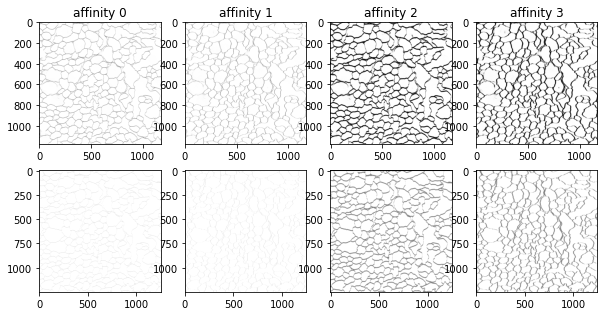

In [19]:
fig,axes = plt.subplots(2,4,figsize=(10,5))

for n,(ax_col,pred,gt) in enumerate(zip(axes.T,aff_pred,gt_affinities)):
    ax_col[0].imshow(-(pred-1),cmap='gray')
    ax_col[1].imshow(-(gt-1),cmap='gray')
    ax_col[0].set_title(f'affinity {n}')

In [17]:
trained_model.offsets

[[-1, 0], [0, -1], [-9, 0], [0, -9]]

In [18]:
aff_pred.shape

torch.Size([4, 1172, 1172])

In [18]:
seg_pred = mutex_watershed(aff_pred.unsqueeze(0).numpy(),trained_model.offsets)

In [19]:
seg_pred.shape

(1, 1, 1172, 1172)

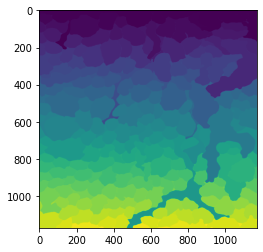

In [24]:
plt.imshow(seg_pred[0,0])

In [20]:
metric_pred_pca = trained_model.image_metric_pca(metric_pred,return_dimensions=None)

In [21]:
metric_pred_pca.shape

(16, 1172, 1172)

/tmp/ipykernel_5670/1520108891.py:7: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  axes[0,1].imshow(skimage.color.label2rgb(gt_seg.numpy()[0]))


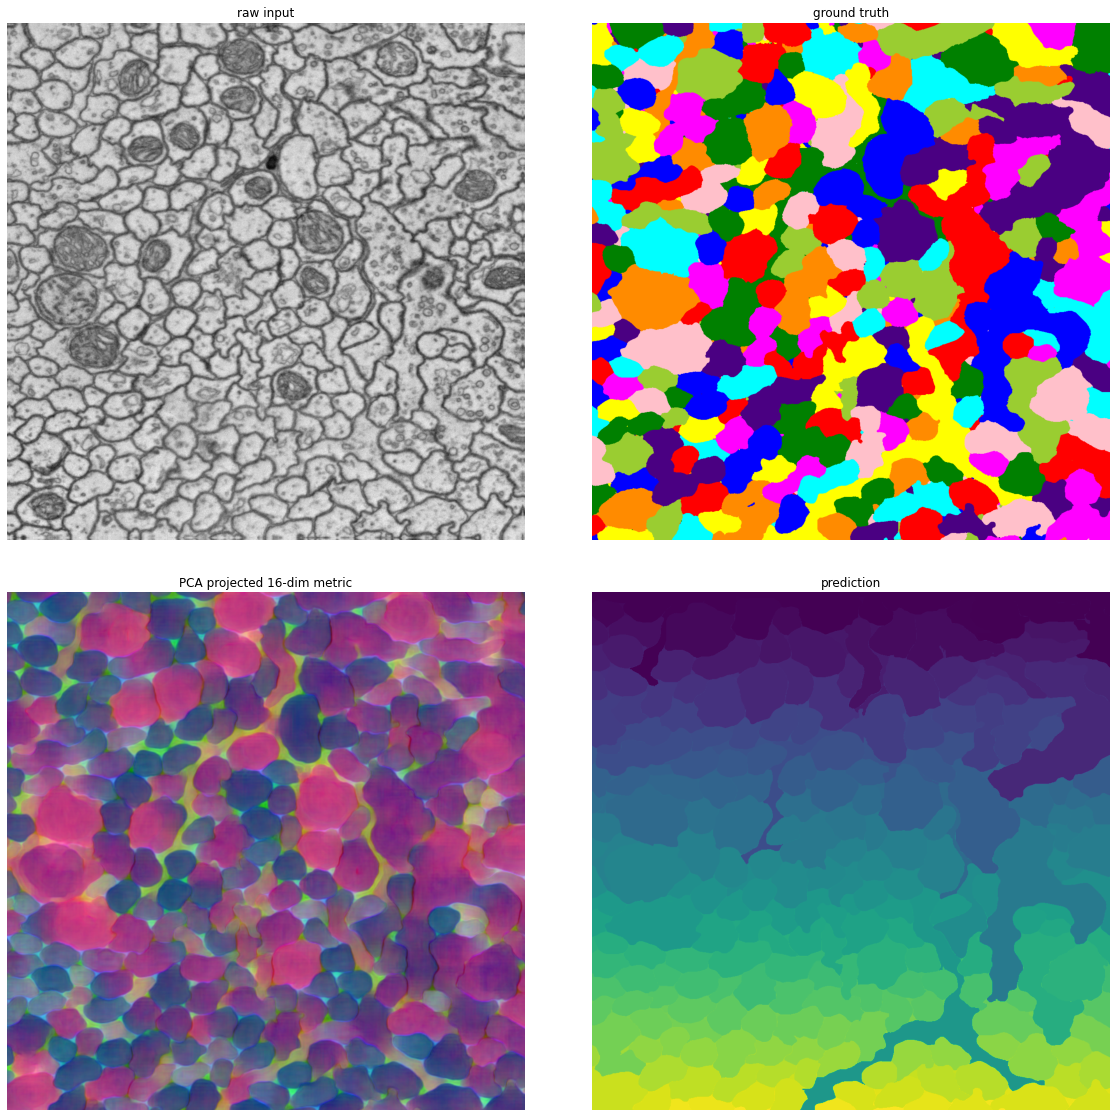

In [381]:
fig,axes = plt.subplots(2,2,figsize=(20,20),gridspec_kw={'wspace':0.1,'hspace':0.1})

axes[0,0].imshow(raw,cmap='gray')
axes[0,0].set_title('raw input')
axes[1,1].imshow(seg_pred[0,0])
axes[1,1].set_title('prediction')
axes[0,1].imshow(skimage.color.label2rgb(gt_seg.numpy()[0]))
axes[0,1].set_title('ground truth')
axes[1,0].imshow(metric_pred_pca[:3].transpose((1,2,0)))
axes[1,0].set_title('PCA projected 16-dim metric')

_=[ax.axis('off') for ax in axes.flatten()]

In [124]:
raw.shape

torch.Size([1260, 1260])

In [125]:
metric_pred.shape

torch.Size([16, 1172, 1172])

In [129]:
(1260-1172)/2

44.0

In [65]:
raw_sliced = raw[44:-44,44:-44].numpy()

In [137]:
raw_sliced.flatten().shape

(1373584,)

In [136]:
metric.numpy().flatten().shape

(1373584,)

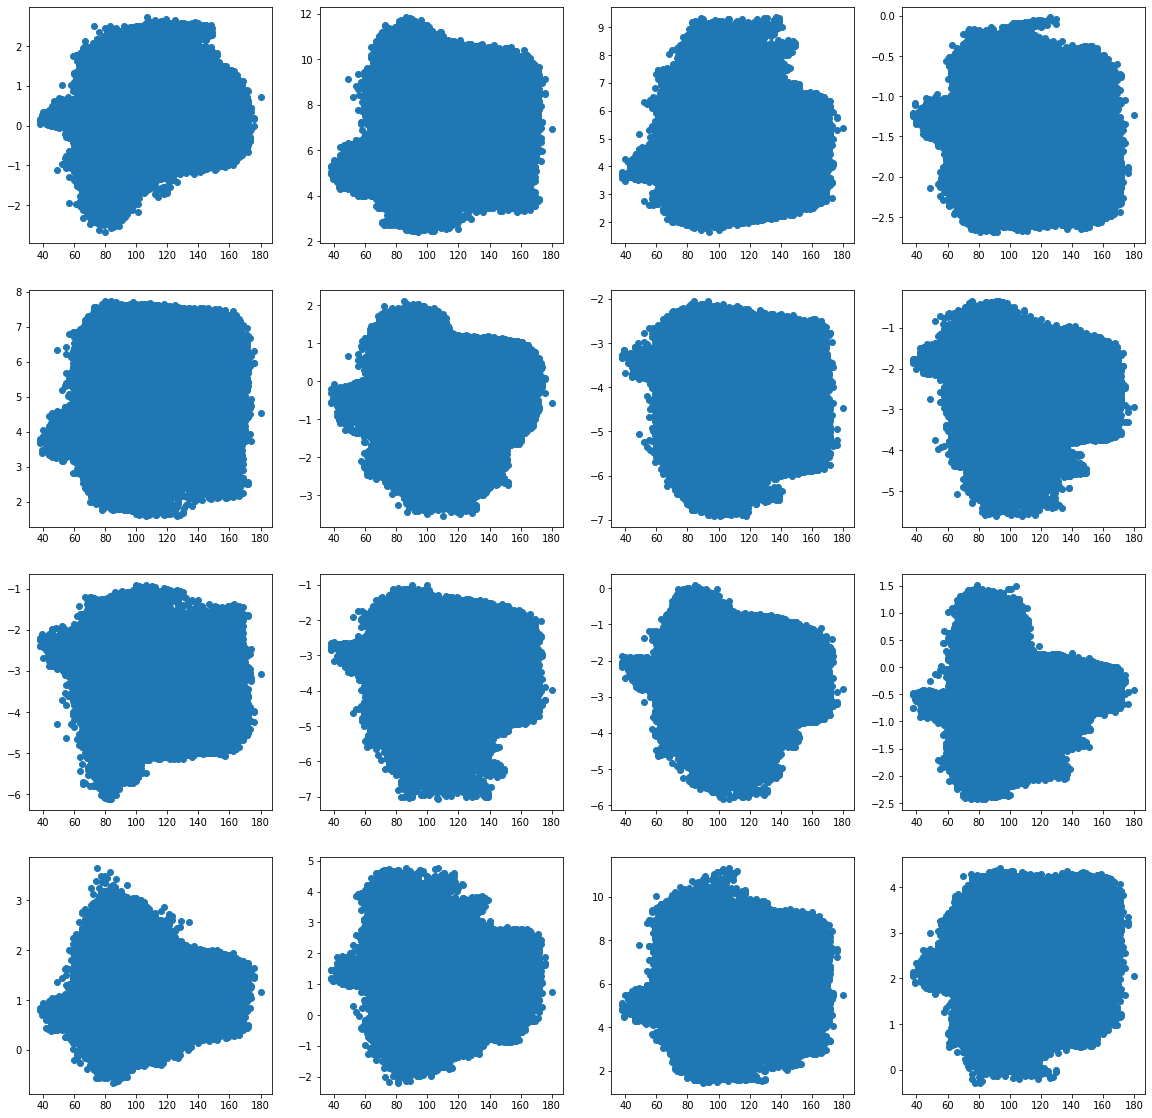

In [138]:
fig,axes = plt.subplots(4,4,figsize=(20,20))

for n,(ax,metric) in enumerate(zip(axes.flatten(),metric_pred)):
    ax.scatter(raw_sliced.flatten(),metric.numpy().flatten())

In [141]:
seg_pred.shape

(1, 1, 1172, 1172)

In [132]:
props = skimage.measure.regionprops_table(
    seg_pred[0,0],
    intensity_image=raw_sliced,
    properties=('label','area','eccentricity',
                'extent','feret_diameter_max',
                'orientation','solidity',
                'mean_intensity','min_intensity',
                'max_intensity'
               ))

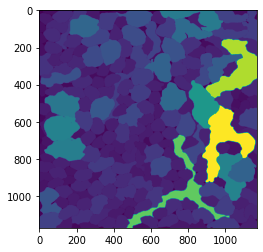

In [31]:
plt.imshow(props['area'][seg_pred[0,0]-1])

In [176]:
def plot_metrics_vs_feature(feature):
    feature_image = props[feature][seg_pred[0,0]-1]
    
    fig,axes = plt.subplots(4,4,figsize=(20,20),sharex=True)

    for n,(ax,metric) in enumerate(zip(axes.flatten(),metric_pred)):
        ax.scatter(feature_image.flatten(),metric.numpy().flatten())
        ax.set_title(f'metric {n+1}')
        if feature in ['area','feret_diameter_max']:
            ax.set_xscale('log')
        
    plt.setp(axes[-1, :], xlabel=feature)
    return axes

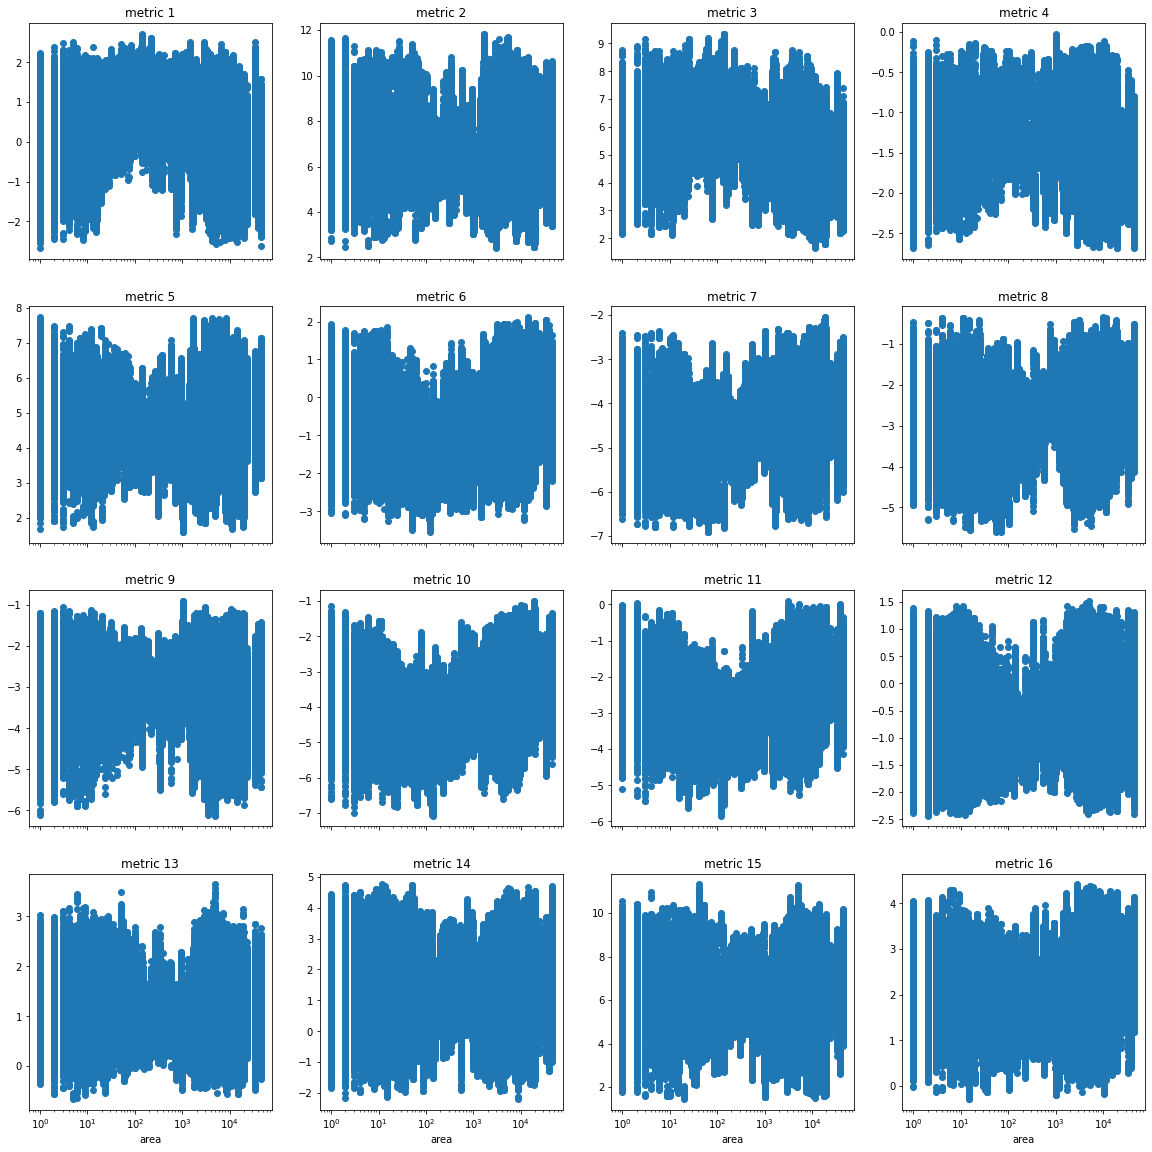

In [167]:
axes = plot_metrics_vs_feature('area')

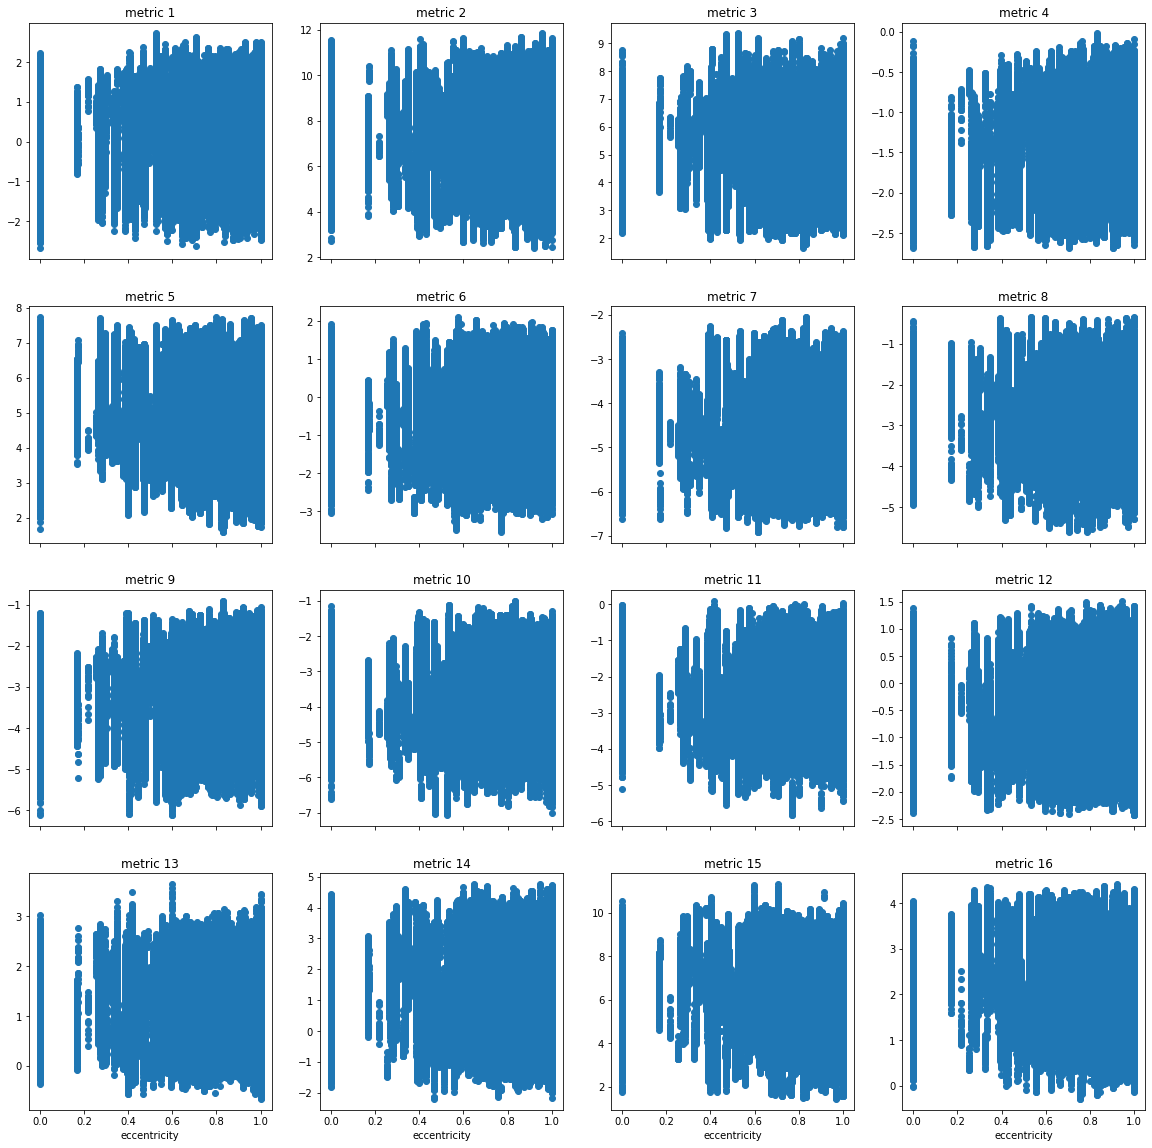

In [168]:
axes = plot_metrics_vs_feature('eccentricity')

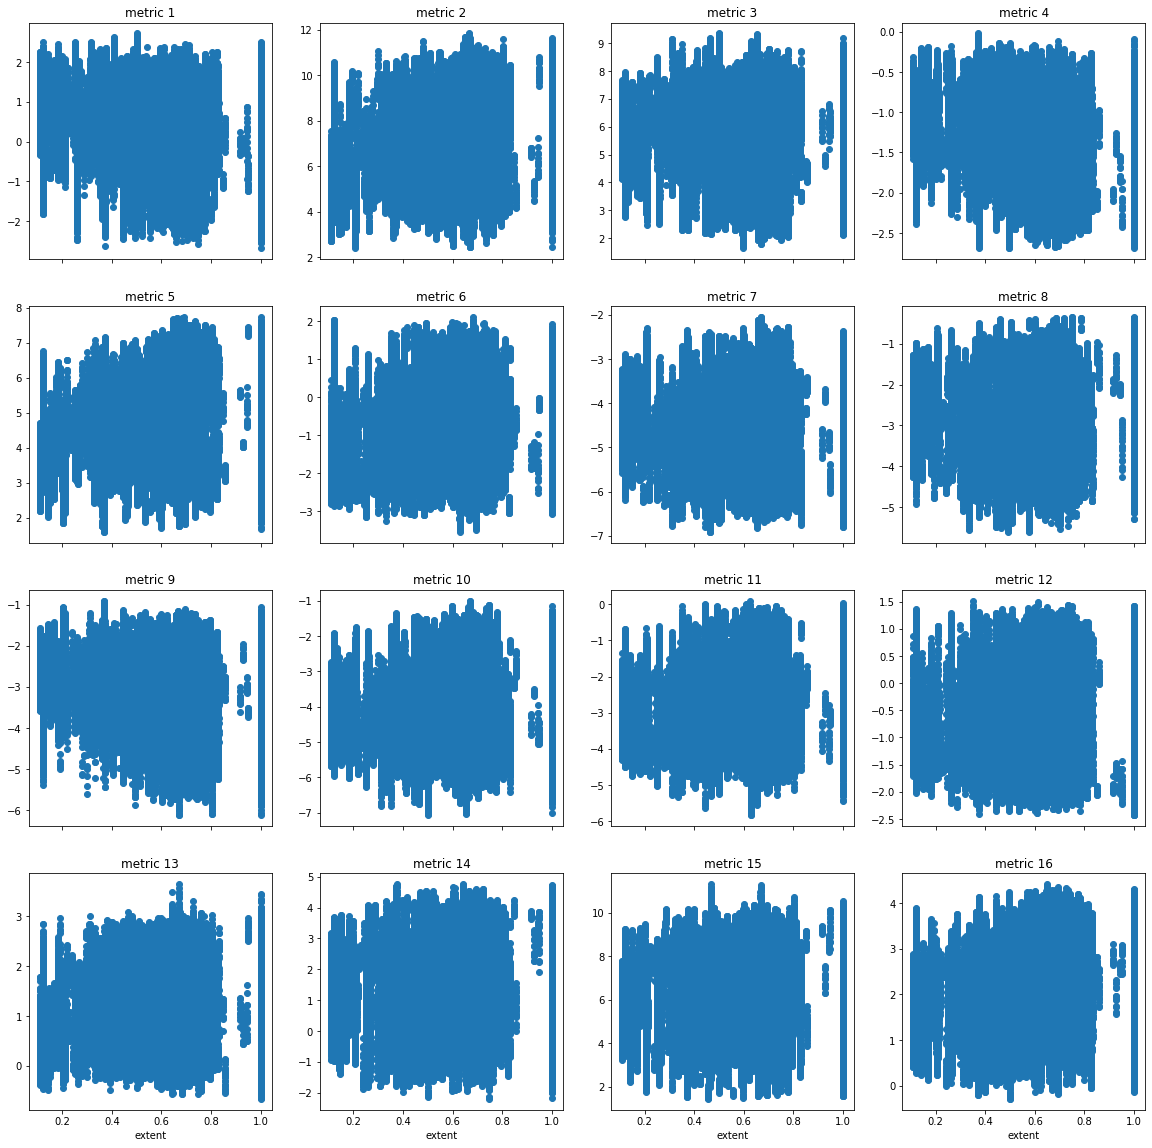

In [169]:
axes = plot_metrics_vs_feature('extent')

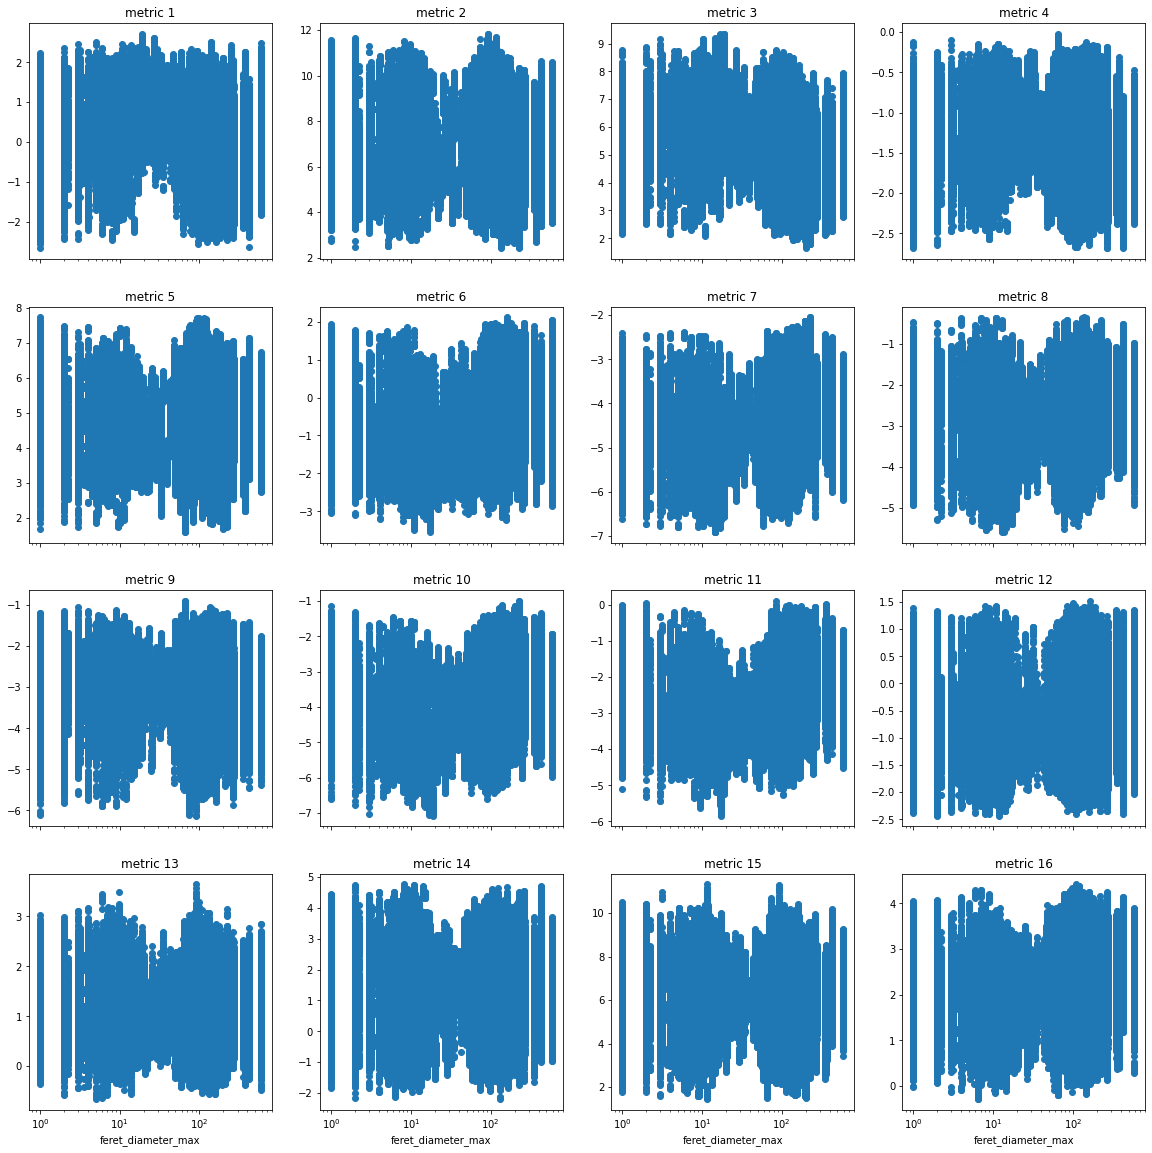

In [170]:
axes = plot_metrics_vs_feature('feret_diameter_max')

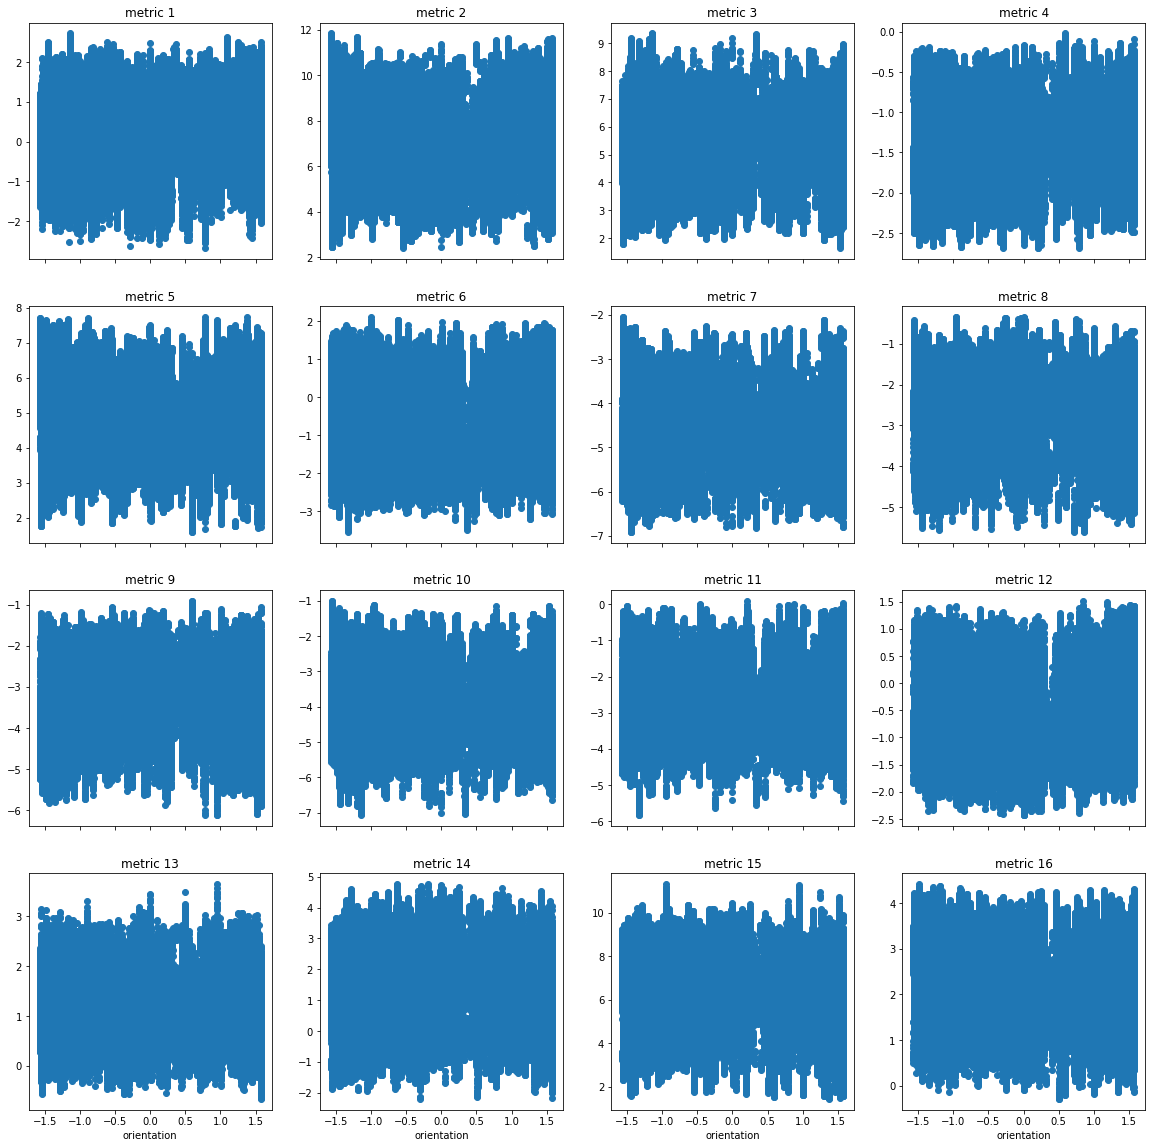

In [171]:
axes = plot_metrics_vs_feature('orientation')

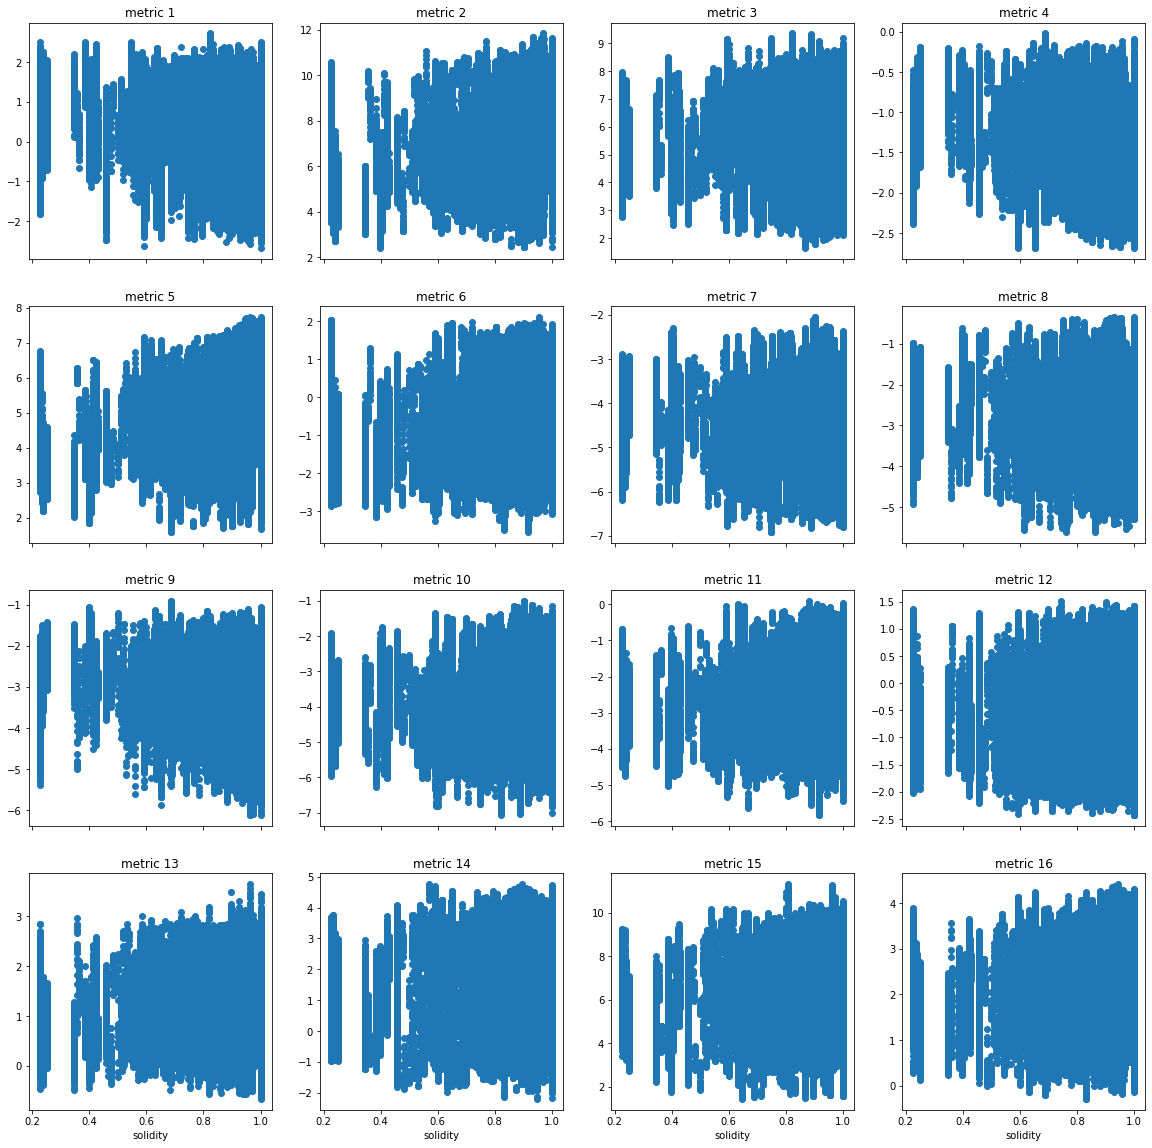

In [172]:
axes = plot_metrics_vs_feature('solidity')

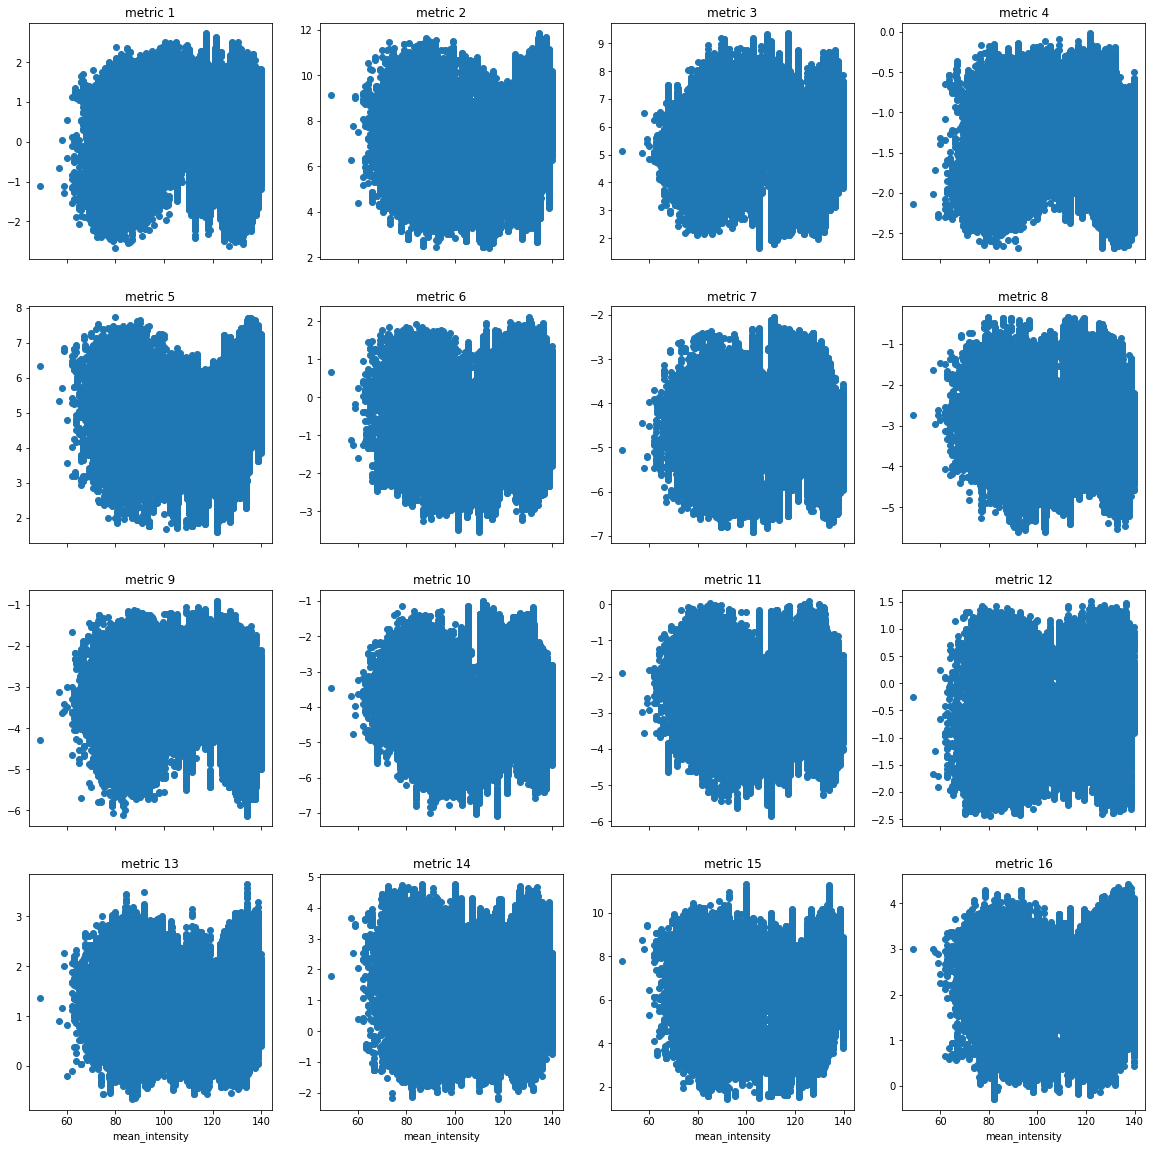

In [177]:
axes = plot_metrics_vs_feature('mean_intensity')

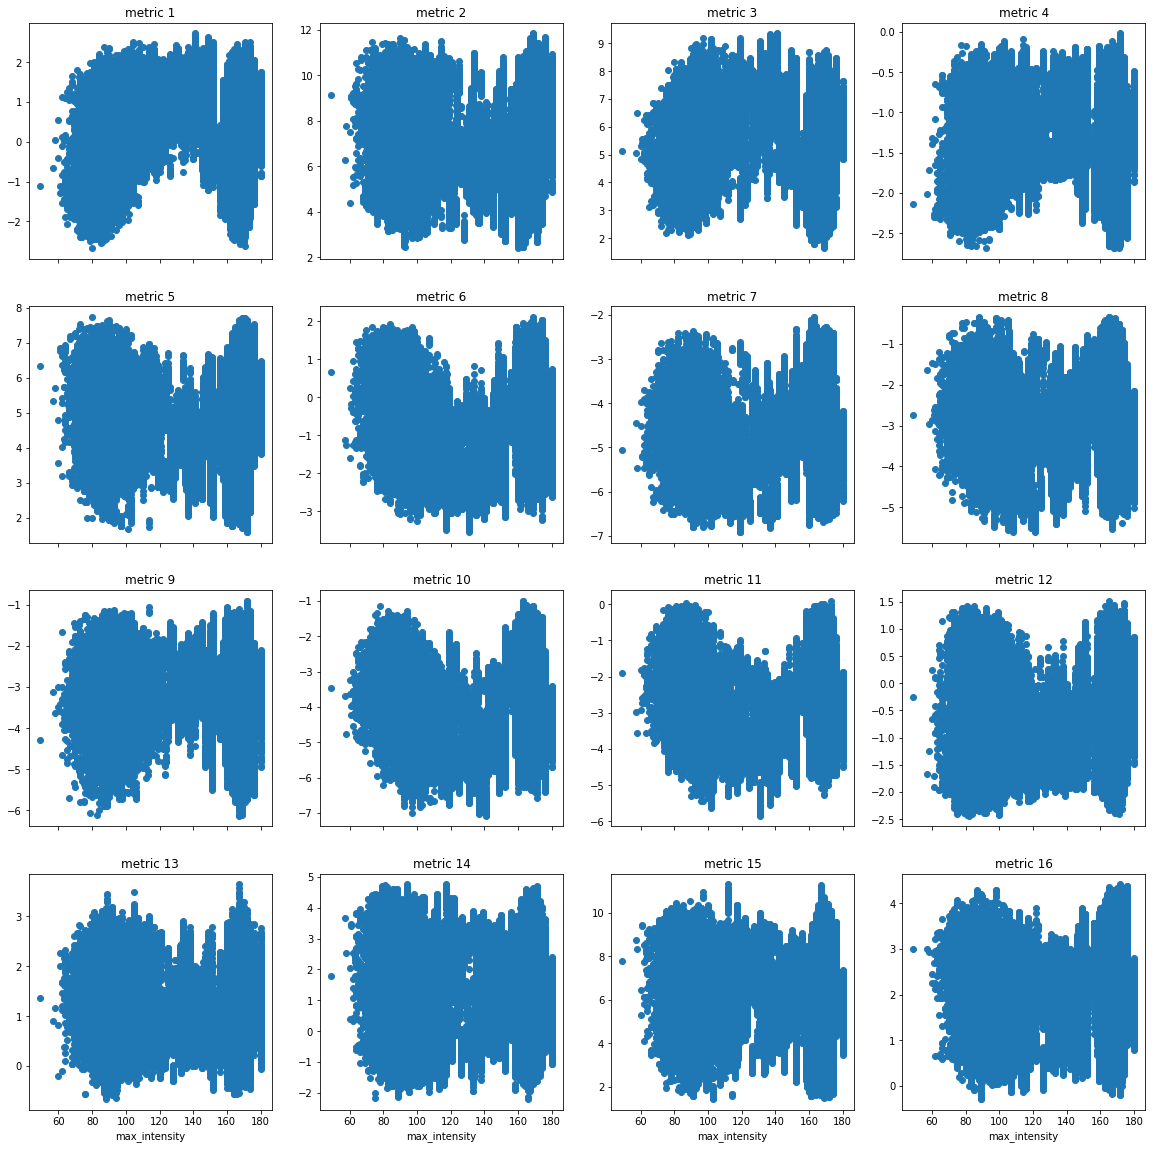

In [178]:
axes = plot_metrics_vs_feature('max_intensity')

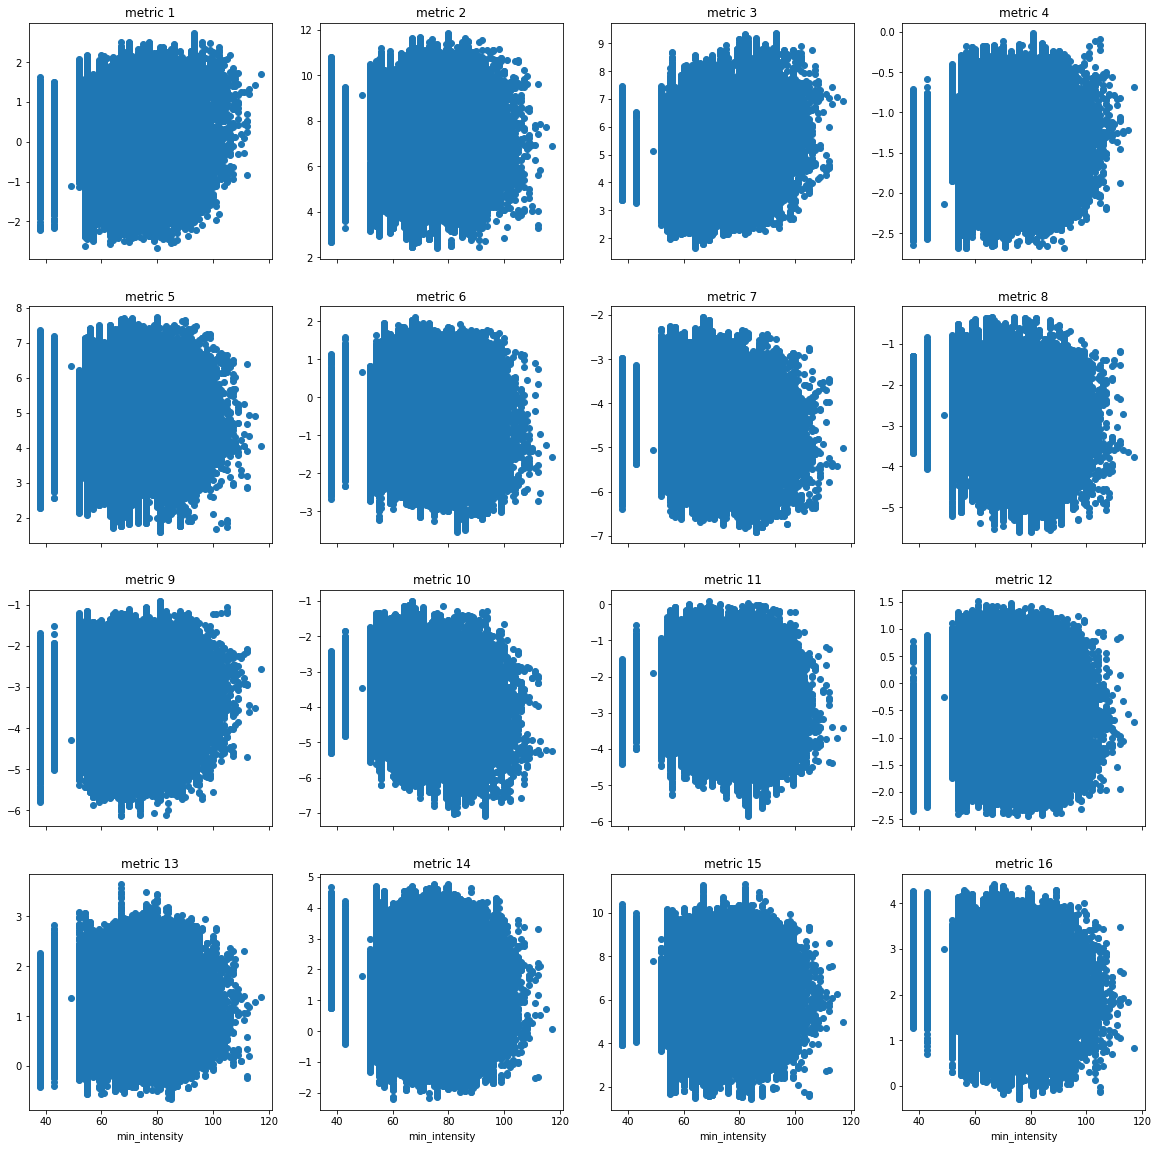

In [179]:
axes = plot_metrics_vs_feature('min_intensity')

In [180]:
from scipy.ndimage import distance_transform_edt

In [191]:
boundaries_pred = skimage.segmentation.find_boundaries(seg_pred[0,0])

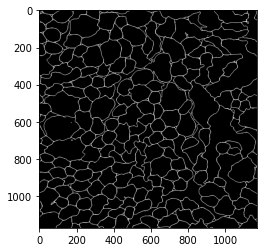

In [202]:
plt.imshow(boundaries_pred,cmap='gray')

In [210]:
dt_pred = distance_transform_edt(1-boundaries_pred)

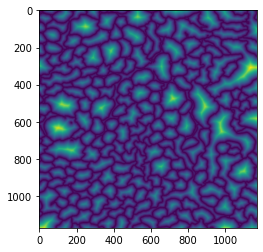

In [213]:
plt.imshow(dt_pred)

In [32]:
# fig,axes = plt.subplots(4,4,figsize=(20,20),sharex=True)

# for n,(ax,metric) in enumerate(zip(axes.flatten(),metric_pred)):
#     ax.scatter(dt_pred.flatten(),metric.numpy().flatten())
#     ax.set_title(f'metric {n+1}')

# _ = plt.setp(axes[-1, :], xlabel='distance to edge')

In [ ]:
props[feature][seg_pred[0,0]-1]

In [34]:
metric_pred.shape

torch.Size([16, 1172, 1172])

In [25]:
mean_embeddings = np.array([skimage.measure.regionprops_table(
    seg_pred[0,0],
    intensity_image=metric_pred[n].numpy(),
    properties=('label','mean_intensity'))['mean_intensity'][seg_pred[0,0]-1]
          for n in range(16)
         ])

In [26]:
mean_embeddings.shape

(16, 1172, 1172)

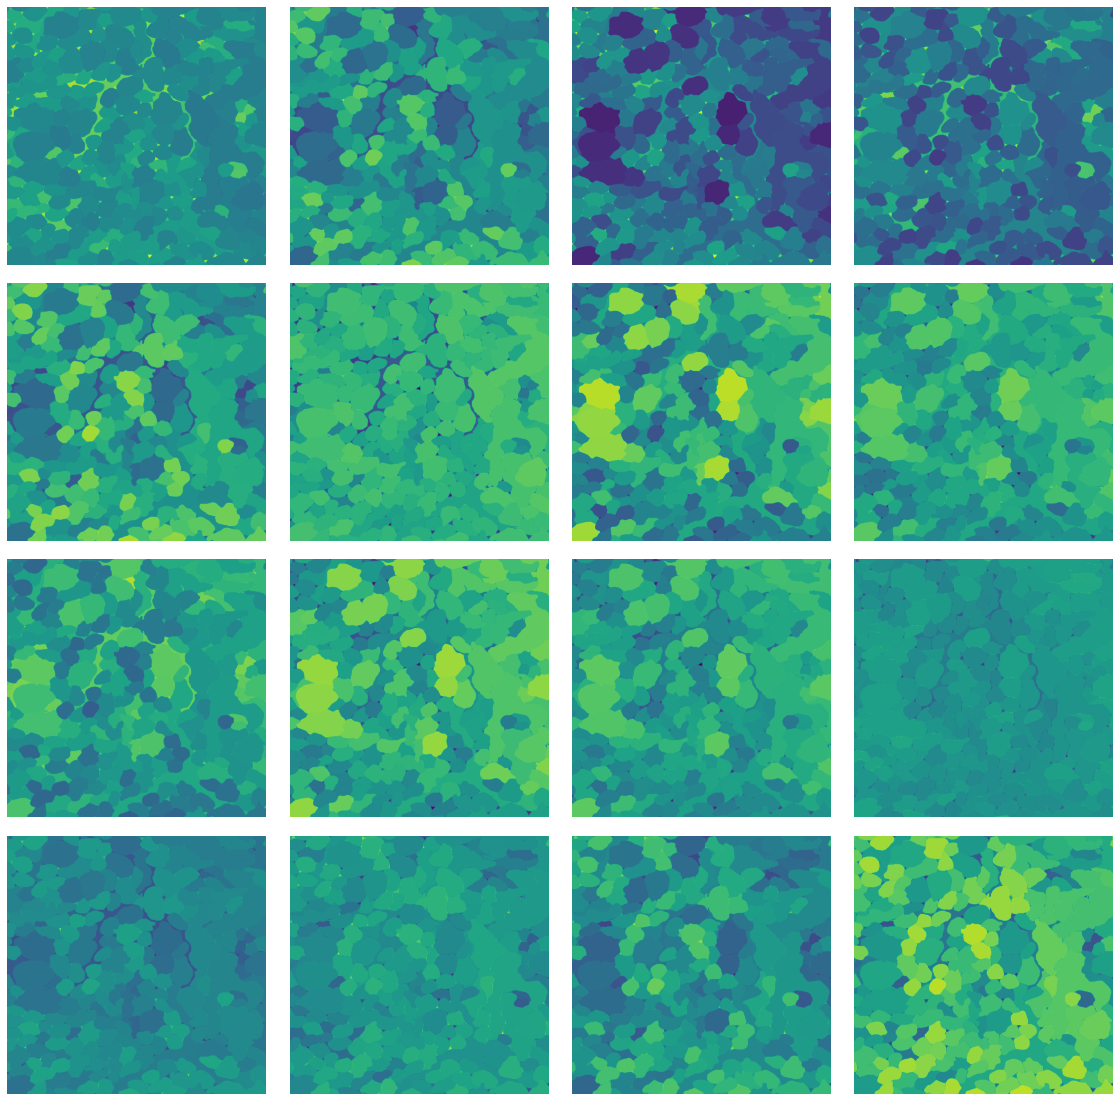

In [44]:
fig,axes = plt.subplots(4,4,figsize=(20,20),gridspec_kw={'wspace':0.05,'hspace':0.07})

for ax,emb in zip(axes.flatten(),mean_embeddings):
    ax.imshow(emb)
    ax.axis('off')

In [124]:
mean_props = [skimage.measure.regionprops_table(
    seg_pred[0,0],
    intensity_image=metric_pred[n].numpy(),
    properties=('label','area','eccentricity',
                'extent','feret_diameter_max',
                'orientation','solidity'))
             for n in range(16)]

In [53]:
def plot_mean_emb_vs_feature(feature):
    
    fig,axes = plt.subplots(4,4,figsize=(20,20),sharex=True)

    for n,(ax,props) in enumerate(zip(axes.flatten(),mean_props)):
        ax.scatter(props[feature],props['mean_intensity'])
        ax.set_title(f'metric dimension {n+1}')
        if feature in ['area','feret_diameter_max']:
            ax.set_xscale('log')
        
    plt.setp(axes[-1, :], xlabel=feature)
    return axes

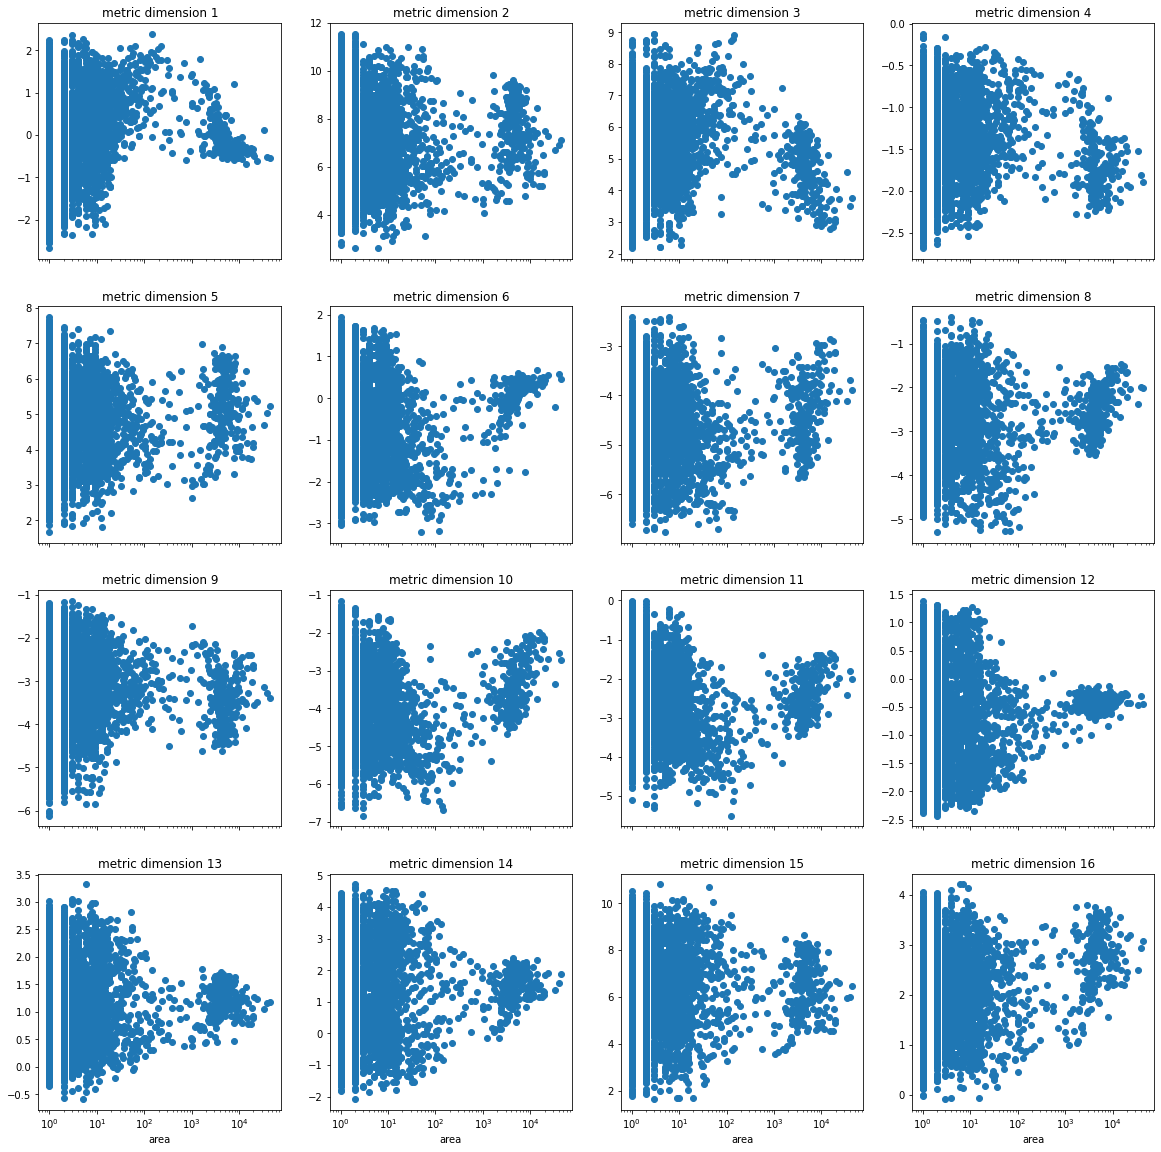

In [54]:
_ = plot_mean_emb_vs_feature('area')

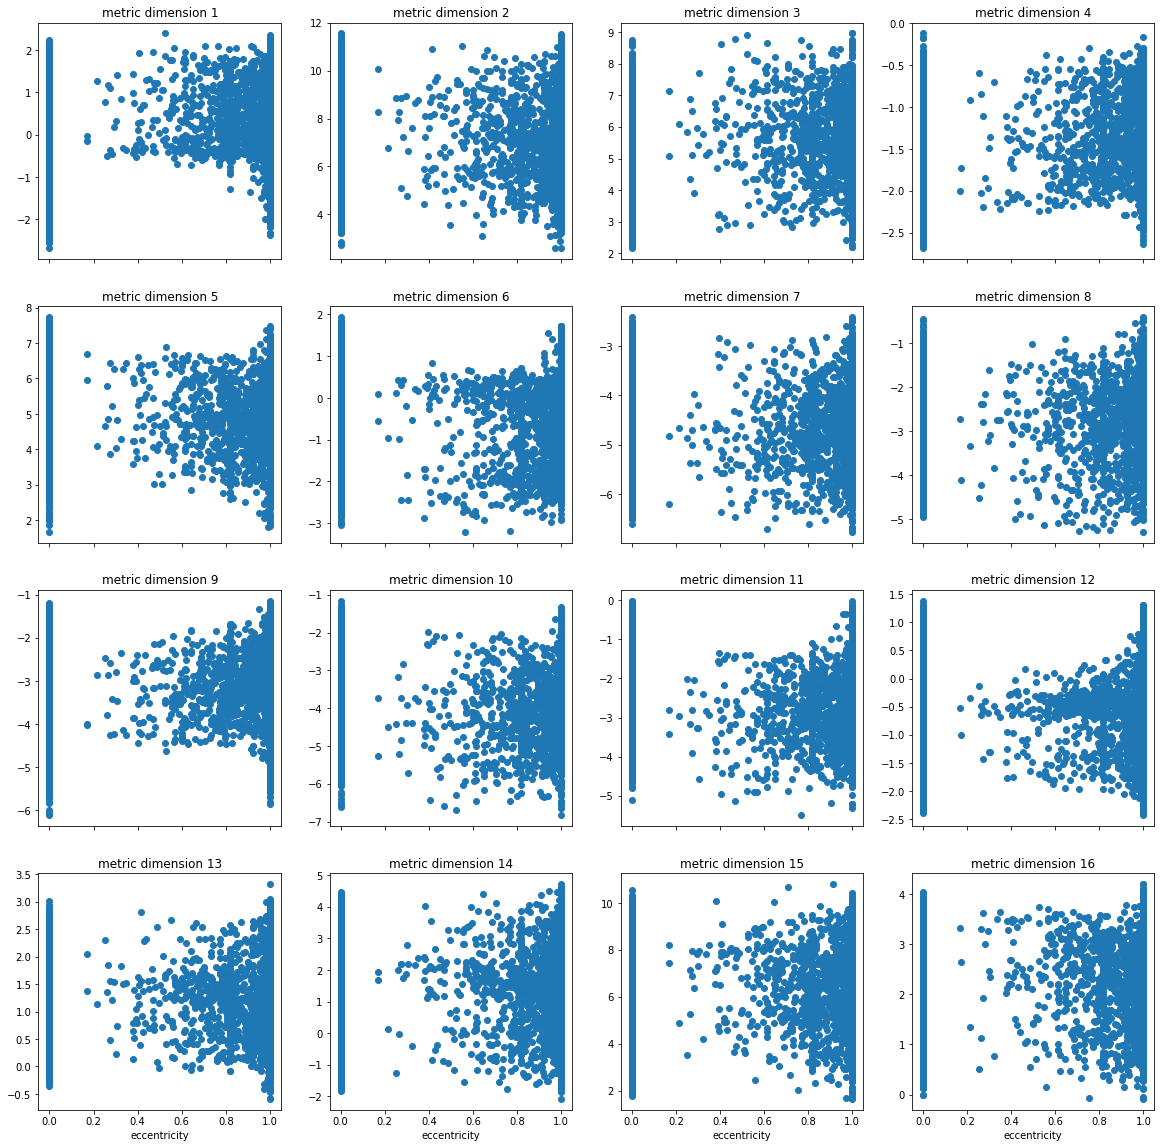

In [55]:
_ = plot_mean_emb_vs_feature('eccentricity')

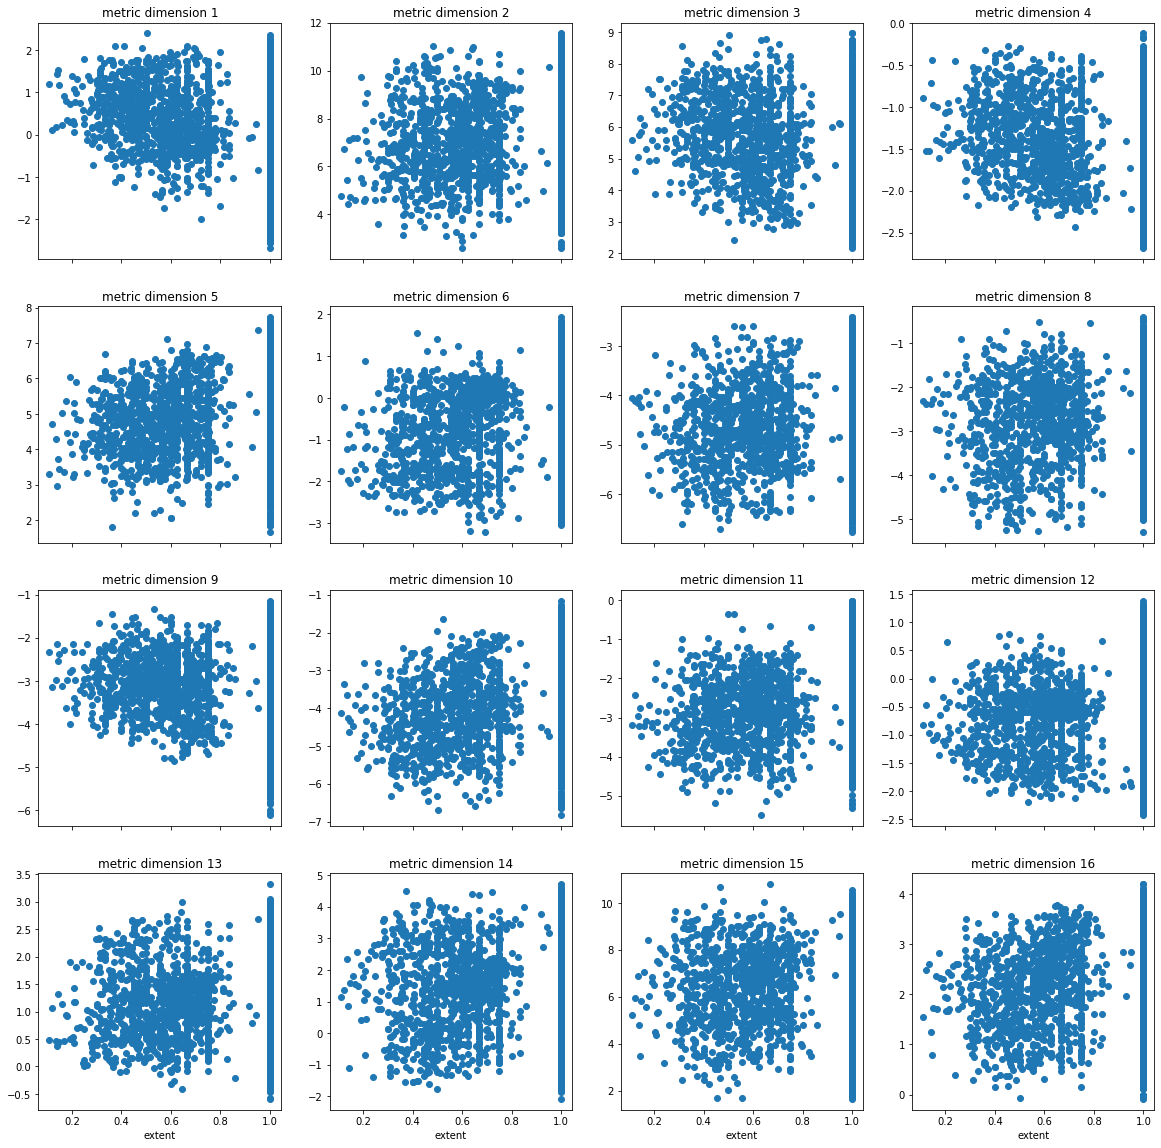

In [56]:
_ = plot_mean_emb_vs_feature('extent')

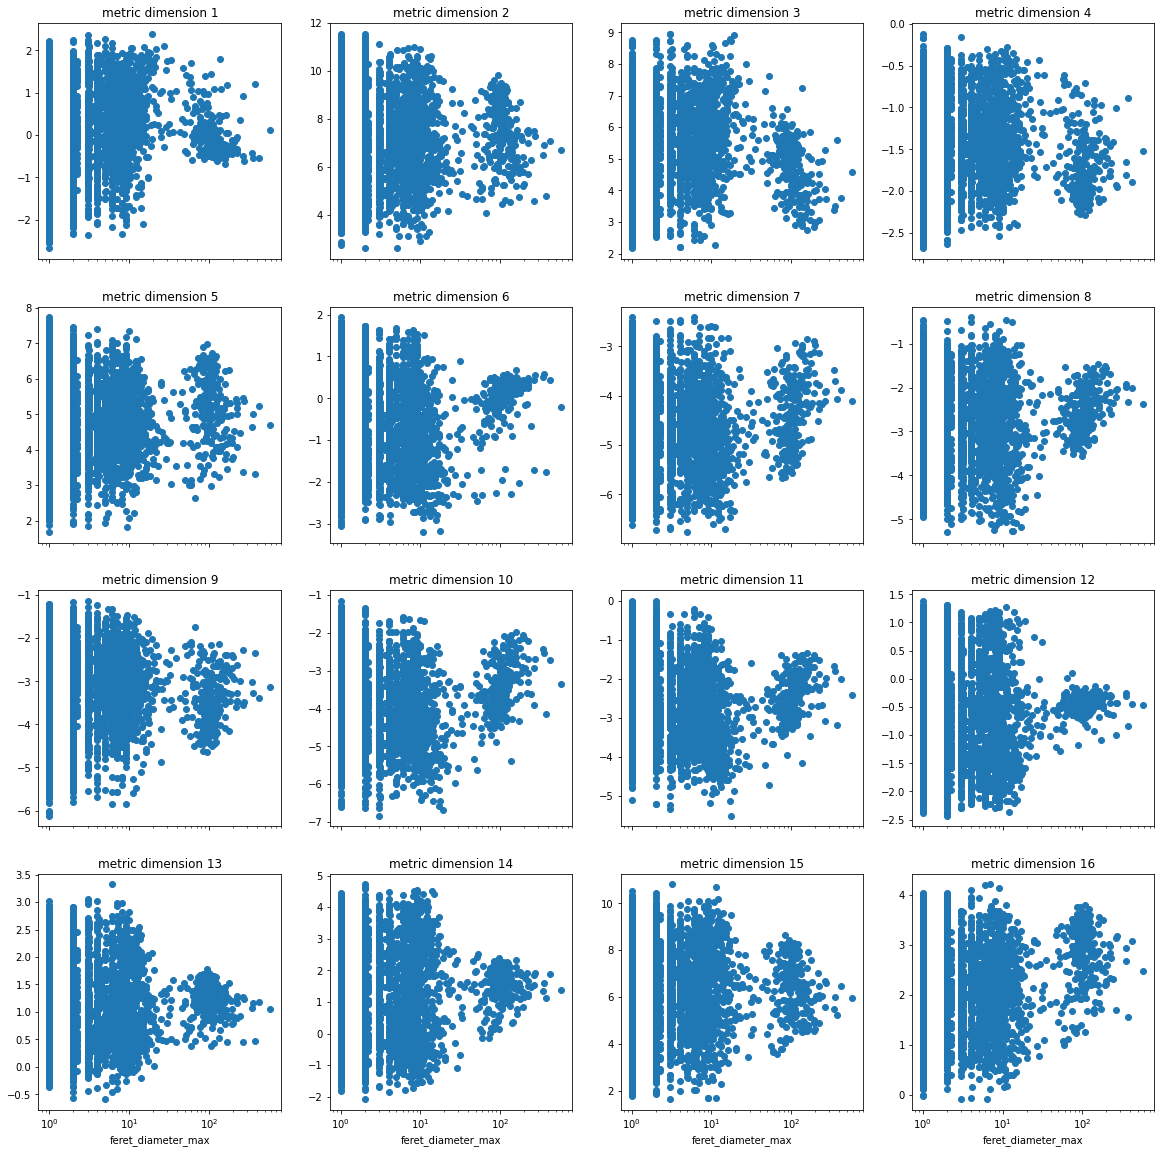

In [57]:
_ = plot_mean_emb_vs_feature('feret_diameter_max')

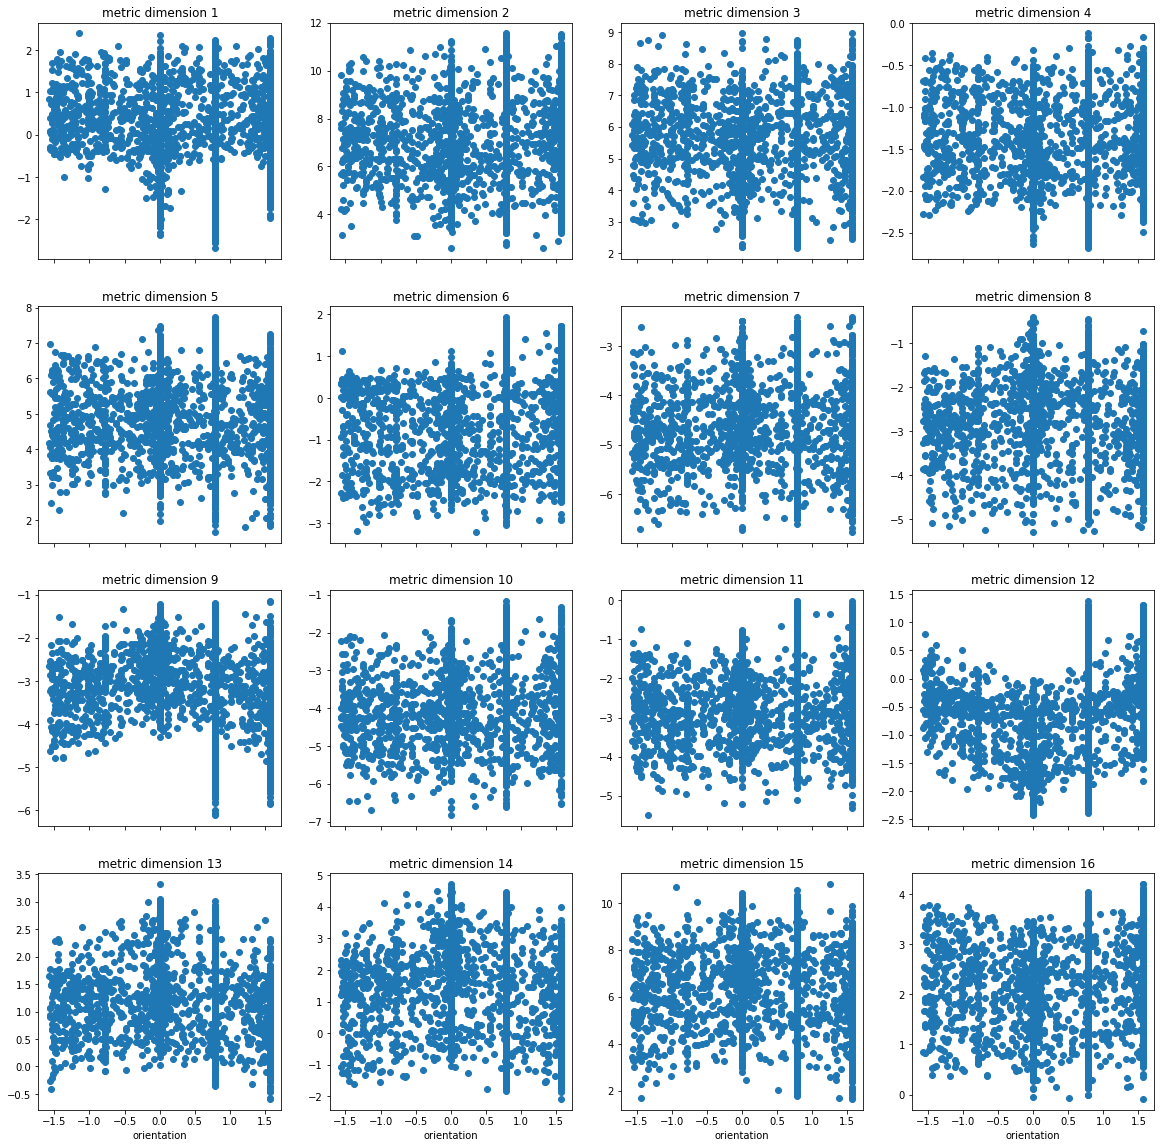

In [60]:
_ = plot_mean_emb_vs_feature('orientation')

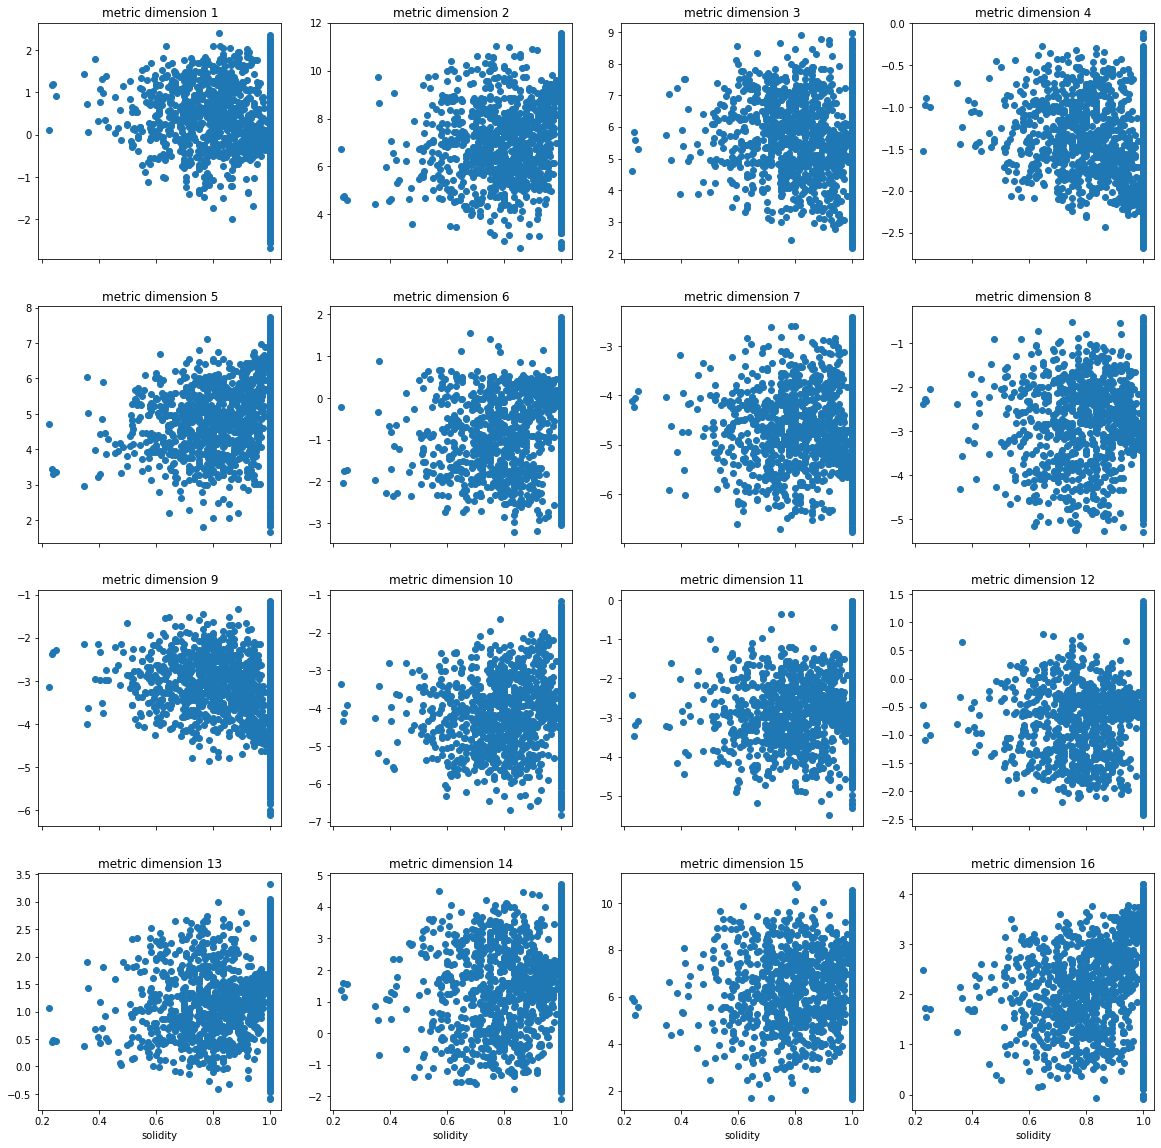

In [61]:
_ = plot_mean_emb_vs_feature('solidity')

# plot against PCA, filter out single pixel segmentation

In [334]:
area_images = props['area'][seg_pred[0,0]-1]
single_pixel_mask = area_images>30

In [335]:
1172**2-single_pixel_mask.sum()

18683

In [336]:
single_pixel_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [337]:
mean_embeddings[...,single_pixel_mask].shape

(16, 1354901)

In [338]:
mean_embeddings.reshape(16,-1).shape

(16, 1373584)

In [339]:
u,i= np.unique(mean_embeddings[...,single_pixel_mask],axis=1,return_index=True)

In [340]:
i.shape

(391,)

In [341]:
len(np.unique(i))

391

In [373]:
s = int(seg_pred.shape[-1]/2-15)

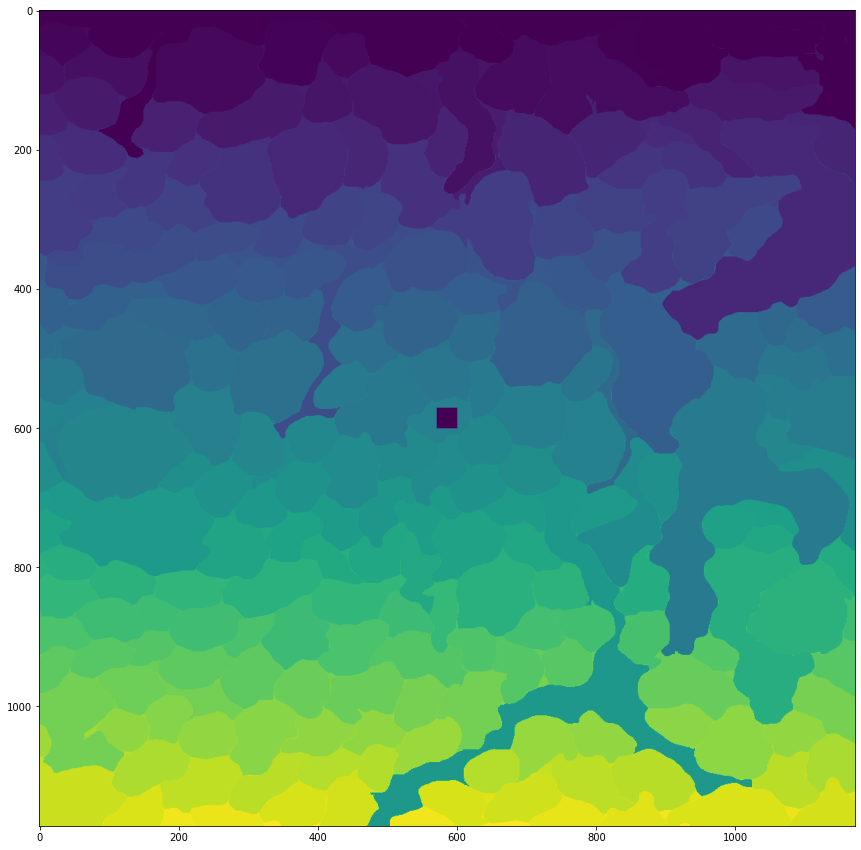

In [378]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
check = seg_pred[0,0].copy()
check[s:-s,s:-s]=0
ax.imshow(
#     skimage.color.label2rgb(check,bg_label=0)
    check
)

In [344]:
(props['area']==44688).sum()

1

In [345]:
seg_pred[0,0,single_pixel_mask].shape

(1354901,)

In [346]:
label_masked=seg_pred[0,0,single_pixel_mask]

In [347]:
matching_labels = np.array([(label_masked[i_]
                            ) for i_ in i])

In [348]:
len(np.unique(matching_labels))

391

In [349]:
pca = PCA()

In [350]:
u_norm = u.copy()

In [351]:
u_norm -= u_norm.min(axis=-1,keepdims=True)
u_norm /= u_norm.max(axis=-1,keepdims=True)

In [352]:
u_pca = pca.fit_transform(u_norm.T)

In [353]:
np.unravel_index(996932,area_images.shape)

(850, 732)

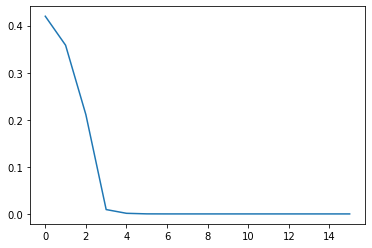

In [354]:
plt.plot(pca.explained_variance_ratio_)

In [355]:
single_pixel_labels = [props['label'][n] for n,area in enumerate(props['area']) if area==1]

In [356]:
props.keys()

dict_keys(['label', 'area', 'eccentricity', 'extent', 'feret_diameter_max', 'orientation', 'solidity', 'mean_intensity', 'min_intensity', 'max_intensity'])

In [357]:
def plot_mean_pca_emb_vs_feature(feature):
    
    fig,axes = plt.subplots(2,2,figsize=(10,10),sharey=True,gridspec_kw={'hspace':0.25,'wspace':0.05})
    
    features = np.array([props[feature][l] for l in matching_labels-1])

    for n,(ax,emb) in enumerate(zip(axes.flatten(),u_pca.T[:4])):
        ax.scatter(y=features,x=emb)
        ax.set_title(f'pca component {n+1} of metric embeddings')
        if feature in ['area','feret_diameter_max']:
            ax.set_yscale('log')
        ax.set_xlabel(f'pca component {n+1}')
#         ax.set_ylabel(feature)
            
        
    plt.setp(axes[:, 0], ylabel=feature)
#     return axes

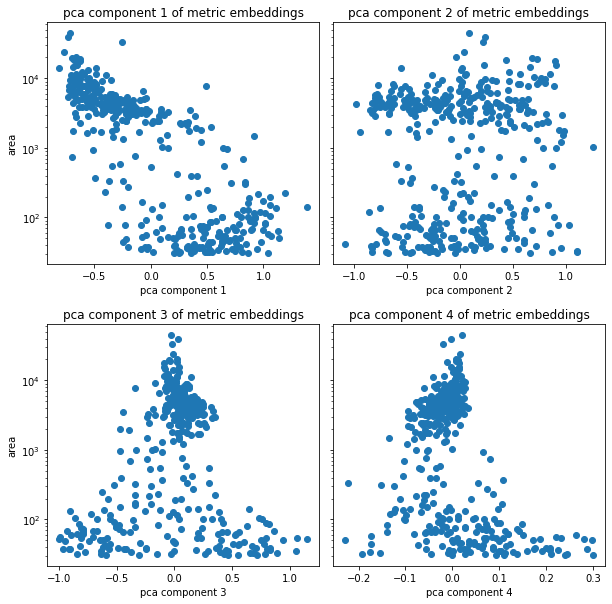

In [358]:
_ = plot_mean_pca_emb_vs_feature('area')

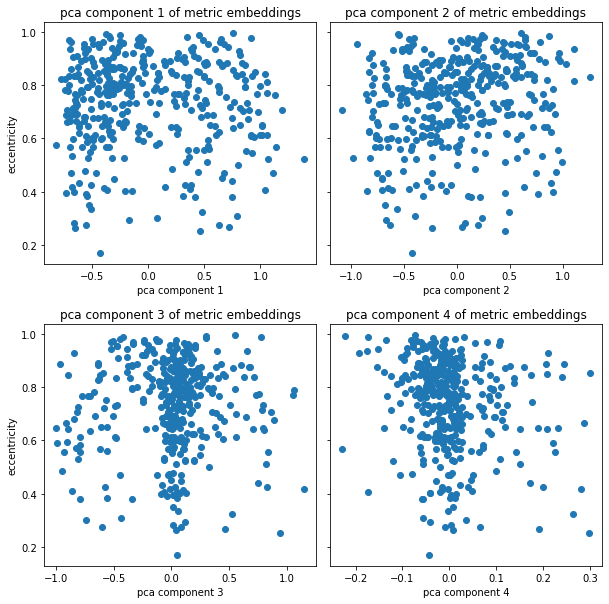

In [359]:
_ = plot_mean_pca_emb_vs_feature('eccentricity')

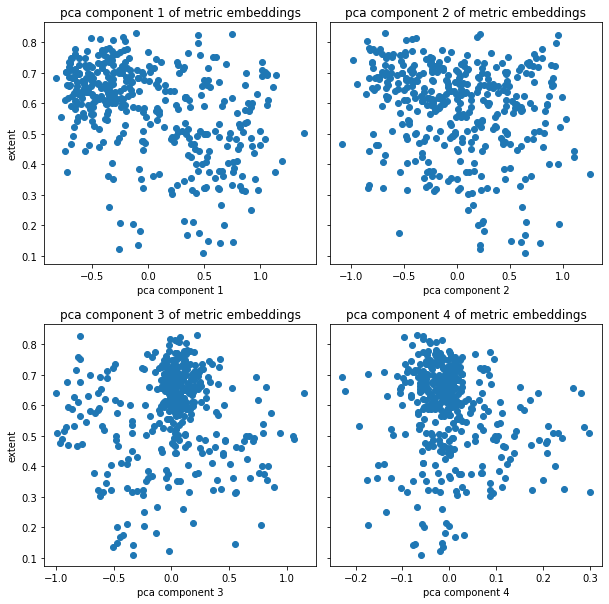

In [360]:
_ = plot_mean_pca_emb_vs_feature('extent')

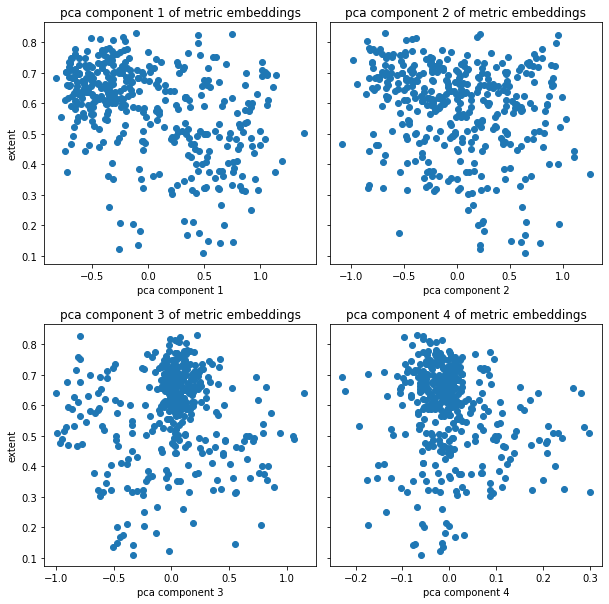

In [361]:
_ = plot_mean_pca_emb_vs_feature('extent')

In [362]:
props.keys()

dict_keys(['label', 'area', 'eccentricity', 'extent', 'feret_diameter_max', 'orientation', 'solidity', 'mean_intensity', 'min_intensity', 'max_intensity'])

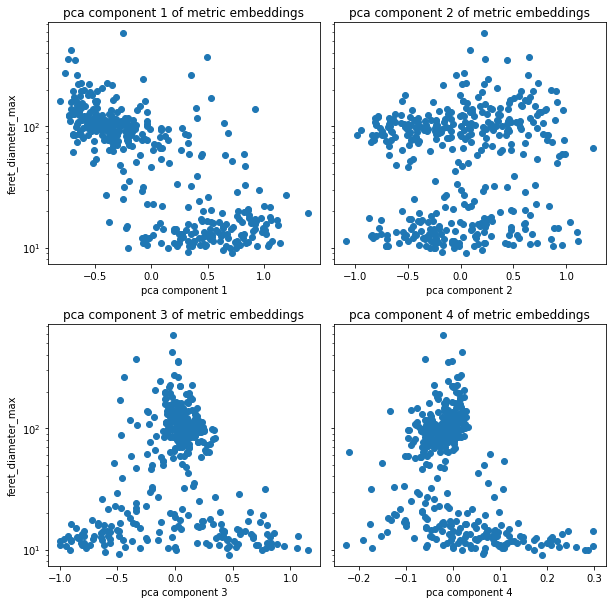

In [363]:
_ = plot_mean_pca_emb_vs_feature('feret_diameter_max')

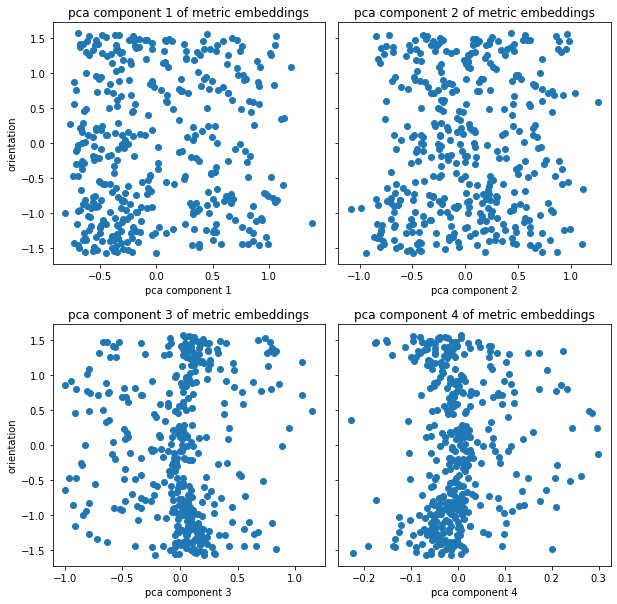

In [364]:
_ = plot_mean_pca_emb_vs_feature('orientation')

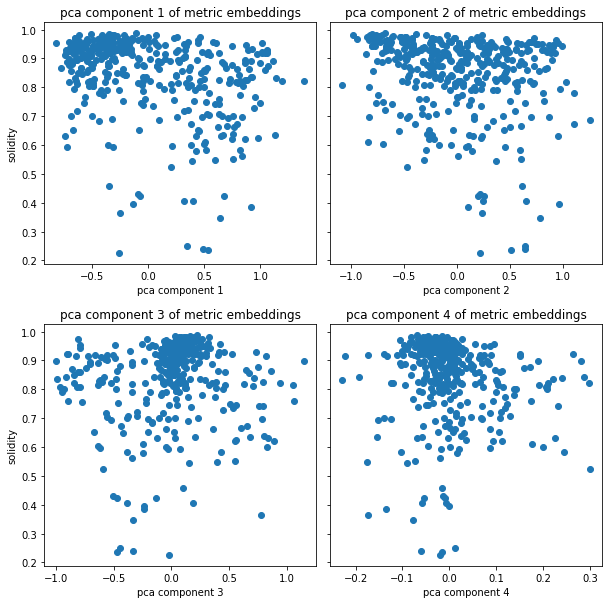

In [365]:
_ = plot_mean_pca_emb_vs_feature('solidity')

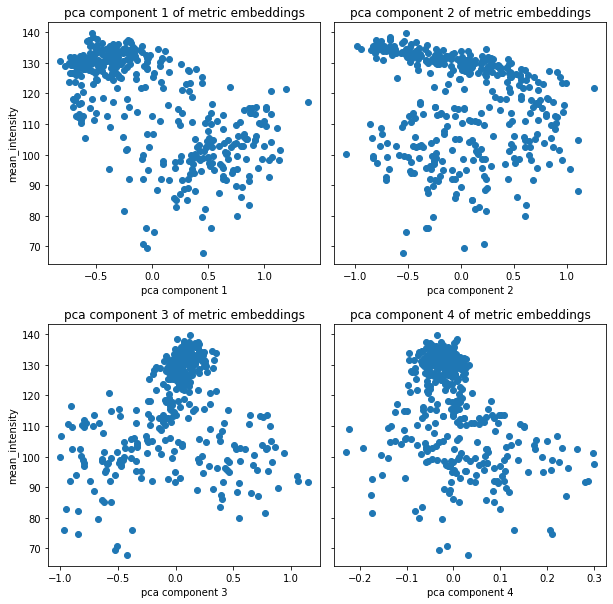

In [366]:
_ = plot_mean_pca_emb_vs_feature('mean_intensity')

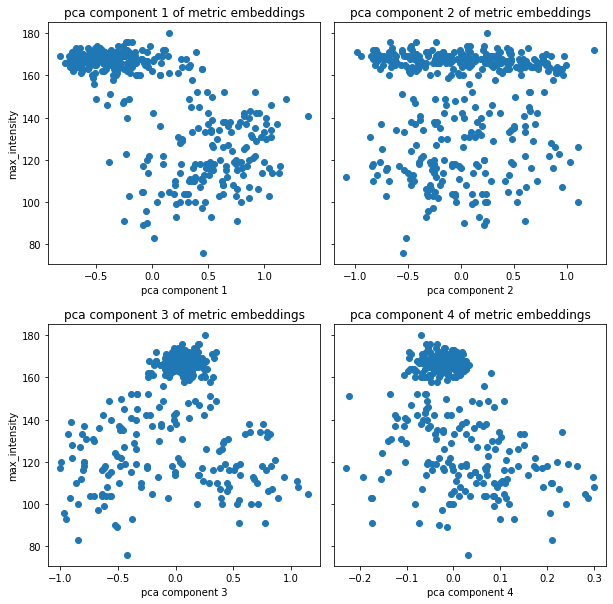

In [367]:
_ = plot_mean_pca_emb_vs_feature('max_intensity')

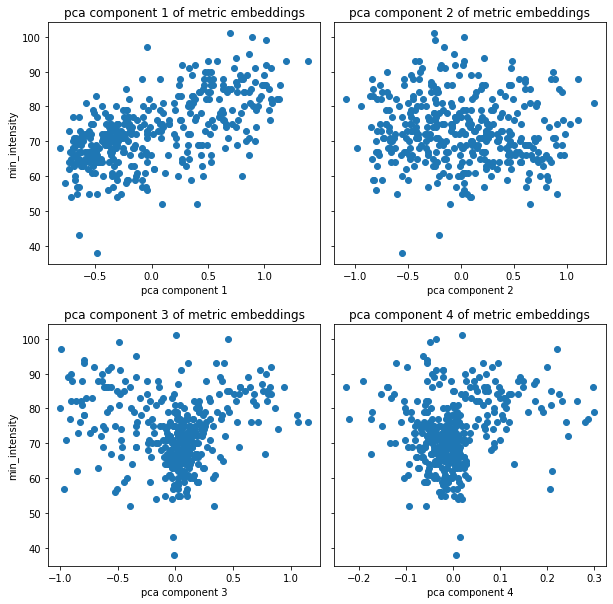

In [368]:
_ = plot_mean_pca_emb_vs_feature('min_intensity')